[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/devdio/2025-ksci-agent/blob/main/02-add-tools.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/devdio/2025-ksci-agent/blob/main/02-add-tools.ipynb)

#  도구(Tool) 추가

챗봇이 "기억만으로" 답변할 수 없는 질문을 처리하기 위해서 외부 환경의 도움을 받아야 한다.  
이번 튜토리얼에서는 `웹 검색 도구`를 사용하여 LLM이 외부 환경과 작용하기 위햇 **도구(Tool)** 를 사용하는 방법에 대해서 진행합니다. 

> LangChain에는 미리 구현된 많은 종류의 도구들이 있습니다. [랭체인에 미리 준비된 도구들](https://python.langchain.com/docs/integrations/tools/)에서 확인 할 수 있습니다.
> 또는 **나만의 도구** 를 파이썬 함수로 간단히 만들 수도 있으며, **MCP(ModelContextProtoco)** 을 사용하여 외부 도구들과 연결할 수 있습니다.

![LangGraph Tool Calling](https://python.langchain.com/assets/images/tool_calling_concept-552a73031228ff9144c7d59f26dedbbf.png)

## 1. 환경 설정

### `.env`파일 설정

이번 튜토리얼에서는 웹 검색도구로 `Tavily 검색 엔진`을 사용합니다. [Tavily 검색 엔진](https://python.langchain.com/docs/integrations/tools/tavily_search/)을 위한 API 키를 `.env`파일에 등록하세요. 

### 패키지 설치

In [2]:
%pip install -qU python-dotenv langgraph langsmith langchain-openai langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:10])
print(os.environ.get("TAVILY_API_KEY")[:10])


sk-proj-8x
tvly-dev-G


## 2. 도구 정의

웹 검색을 위한 도구를 정의합니다. 이 튜토리얼에서는 [Tavily 서비스](https://www.tavily.com/)를 도구로 사용합니다.   
도구를 사용하기 위해서는 API키의 등록이 필요합니다.

In [7]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=3)

In [8]:
# 테스트
search_tool.invoke("2025 윔블던 테스트에 대해서 알려줘")

{'query': '2025 윔블던 테스트에 대해서 알려줘',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://londonstory.tistory.com/entry/2025-%EC%9C%94%EB%B8%94%EB%8D%98-%EC%99%84%EC%A0%84-%EC%A0%95%EB%B3%B5-%ED%8B%B0%EC%BC%93%EB%B6%80%ED%84%B0-%EB%93%9C%EB%A0%88%EC%8A%A4%EC%BD%94%EB%93%9C-%ED%98%84%EC%9E%A5-%EA%BF%80%ED%8C%81%EA%B9%8C%EC%A7%80',
   'title': '[2025 윔블던 테니스 대회 정보] 일정 ,티켓 예매 방법 - 런던 스토리',
   'content': "[2025 윔블던 테니스 대회 정보] 일정 ,티켓 예매 방법 *   영국 런던 여행 영국 런던 여행 [2025 윔블던 테니스 대회 정보] 일정 ,티켓 예매 방법 🎾 런던 여름의 품격, 윔블던 테니스 대회 정보 🎟 윔블던 'The Queue' 현장 티켓 구매 요약 **📌 런던 여행 중 하루를 특별하게 만들고 싶다면, 윔블던 테니스가 정답입니다!** #### '영국 런던 여행' 카테고리의 다른 글 | [[ 6월 영국 여행 준비] 날씨, 옷차림부터 추천 일정까지](https://londonstory.tistory.com/entry/2025-6%EC%9B%94-%EC%98%81%EA%B5%AD-%EC%97%AC%ED%96%89-%EC%A4%80%EB%B9%84-%EB%82%A0%EC%94%A8-%EC%98%B7%EC%B0%A8%EB%A6%BC%EB%B6%80%ED%84%B0-%EC%B6%94%EC%B2%9C-%EC%9D%BC%EC%A0%95%EA%B9%8C%EC%A7%80-%EC%99%84%EB%B2%BD-%EA%B0%80%EC%9D%B4%EB%93%9C)(19) | 2025.06.02 | 

## 3. 그래프 생성

![add_tool_01](statics/02_add_tool_01.png)

### 상태 정의

In [19]:
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

# 상태 
class State(TypedDict):
    messages: Annotated[list, add_messages]

### 챗봇 노드 정의 

In [21]:
tools = [search_tool]

# 챗봇 노드 
def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    print("\n\n 🌳🌳🌳", state["messages"], "\n\n\n")
    
    # 💡 LLM이 검색 엔진을 사용할 수 있도록 LLM에게 알려줍니다. 
    # 이 때 LLM이 도구(Tool)을 사용할 수 있어야 합니다.
    llm_with_tools = llm.bind_tools(tools)
    
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}



LLM이 검색 도구를 사용할 수 있도록 `bind_tools()` 함수를 사용하여 등록합니다.

### 💡 도구 실행 위한 노드

도구 실행을 위해서는 **도구 실행을 위한 별도의 노드(도구 실행 노드)가 그래프에 포함되어야 합니다.   
LangGraph에는 도구 실행을 위한 미리 정의된(prebuilt) 노드가 준비되어있습니다. `ToolNode`를 그래프에 추가합니다.
도구 호출에 대한 자세한 내용은 [LangGraph 도구 호출](https://python.langchain.com/docs/concepts/tool_calling/) 페이지를 참고하세요.

In [22]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)


### 노드 추가

In [23]:
# 그래프 생성
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

### 엣지 그리고 조건부 엣지(Conditional Edge) 추가

조건부 엣지(conditional edges) 는 하나의 노드에서 조건에 맞는 다른 노드로 이동하기 위해 사용됩니다.    
`tools_condition` 는 LLM의 리턴값에 **도구 호출이 필요하면 Tool노드**로 이동시키고, **그렇지 않으면 `END`노드**로 이동시킨다.  

In [24]:
from langgraph.prebuilt import tools_condition

# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고,
# 바로 응답해도 되는 경우에는 "END"를 반환합니다.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

In [25]:
# 도구가 호출될 때마다, 다음 단계를 결정하기 위해 다시 챗봇으로 돌아갑니다.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# END 노드로 이동은 tool_condition 내부에 정의되어 있어서 명시적으로 지정하지 않습니다.

graph = graph_builder.compile()

이 부분은 LangGraph에서 제공하는 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) 을 사용하면 간격하게 작성할 수 있다.

### 시각화

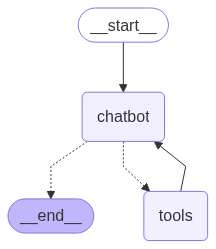

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 4. 챗봇 실행

In [ ]:
# You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
            
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
    except:
        # input()을 사용할 수 없는 경우의 대체 처리(fallback)
        user_input = "지구에서 달까지의 거리를 알려줘?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

## 전체 코드

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 📌 ToolNode 추가
tool_node = ToolNode(tools=[tool])

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

## END